## **MixUp**

Il mixup è una tecnica di data augmentation utilizzata durante l'addestramento delle reti neurali. L'idea fondamentale è quella di creare nuovi esempi di training mescolando coppie di esempi esistenti nel dataset.

### 1. **Scelta degli Esempi da Mescolare**
Si selezionano casualmente due esempi dal dataset di training. Questi possono essere immagini, testi, o qualsiasi altro tipo di dati. Chiamiamo questi esempi $ x_1 $ e $ x_2 $, e le loro corrispondenti etichette (o target) $ y_1 $ e $ y_2 $.

### 2. **Generazione del Coefficiente di Mixup**
Si genera un coefficiente, chiamato $ \lambda $, che determina quanto ogni esempio contribuirà al nuovo esempio sintetico. Questo valore è in genere estratto da una distribuzione Beta, $ \text{Beta}(\alpha, \alpha) $, dove $ \alpha $ è un iperparametro che controlla la forma della distribuzione. Valori comuni per $ \alpha $ sono 0.1, 0.2, o 0.4.

### 3. **Combinazione degli Input**
I due input selezionati vengono combinati usando il coefficiente $ \lambda $ per formare un nuovo input $ \tilde{x} $. La formula è:
$$ \tilde{x} = \lambda x_1 + (1 - \lambda) x_2 $$
Questo significa che il nuovo input è una combinazione lineare dei due input originali.

### 4. **Combinazione delle Etichette**
Analogamente agli input, anche le etichette vengono combinate usando lo stesso coefficiente $ \lambda $. Se le etichette sono rappresentate come vettori (come nel caso di classificazione con più classi), la combinazione è:
$$ \tilde{y} = \lambda y_1 + (1 - \lambda) y_2 $$
Questa operazione crea un'etichetta "mista" che rappresenta la combinazione delle etichette originali.

### 5. **Addestramento con Dati Mixup**
Il modello viene poi addestrato usando il nuovo insieme di esempi di input $ \tilde{x} $ e le corrispondenti etichette miste $ \tilde{y} $. Durante l'addestramento, il modello impara a generalizzare tra gli esempi, anziché memorizzare caratteristiche specifiche di ciascun esempio.

### Focus su distribuzione Beta

[Applet interattiva](https://homepage.stat.uiowa.edu/~mbognar/applets/beta.html)

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/f/f3/Beta_distribution_pdf.svg/1280px-Beta_distribution_pdf.svg.png" width=500 />

#### 1. **Generazione del Coefficiente di Mixup ($\lambda$)**
La chiave del mixup è la generazione di un coefficiente, $\lambda$, che determina come combinare due esempi di training. Questo coefficiente è generato casualmente per ogni coppia di esempi, e la distribuzione Beta è utilizzata per questo scopo. 

#### 2. **La Distribuzione Beta**
La distribuzione Beta, parametrizzata da $\alpha$ e $\beta$, è una distribuzione di probabilità continua definita sull'intervallo [0, 1]. Nel contesto del mixup, i parametri $\alpha$ e $\beta$ sono spesso impostati allo stesso valore, creando una distribuzione simmetrica. Questo valore comune è un iperparametro del processo di mixup.

#### 3. **Impatto dei Parametri $\alpha$ e $\beta$**
- **$\alpha = \beta = 1$**: Questo caso speciale rende la distribuzione Beta una distribuzione uniforme. Il coefficiente $\lambda$ avrà una probabilità uguale di assumere qualsiasi valore tra 0 e 1.
- **$\alpha, \beta > 1$**: La distribuzione tende a concentrarsi intorno a 0.5, incoraggiando un mix più equilibrato degli esempi.
- **$\alpha, \beta < 1$**: La distribuzione tende a favorire valori vicino a 0 o 1, portando a combinazioni meno equilibrate, dove uno degli esempi ha un peso maggiore.

#### 4. **Calcolo di $\lambda$**
Per ogni coppia di esempi di training, un valore di $\lambda$ è estratto dalla distribuzione Beta($\alpha, \beta$). Questo valore determina il peso di ciascun esempio nella combinazione.


### Sitografia

https://www.tensorflow.org/api_docs/python/tfm/vision/augment/MixupAndCutmix

https://keras.io/guides/keras_cv/cut_mix_mix_up_and_rand_augment/

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
num_classes = 100
input_shape = (32, 32, 3)

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar100.load_data()

In [3]:
x_train = x_train / 255.
y_train = tf.keras.utils.to_categorical(y_train, num_classes)

x_test = x_test / 255.
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

In [4]:
new_x_train = []
new_y_train = []

for _ in range(10):
    idx = np.random.permutation(len(x_train))
    idx_2 = np.random.permutation(len(x_train))
    
    for i in range(len(x_train)):    
        l = np.random.random() * .15 + .1
        new_x_train.append((x_train[idx[i]] * l) + (x_train[idx_2[i]] * (1 - l)))
        new_y_train.append((y_train[idx[i]] * l) + (y_train[idx_2[i]] * (1 - l)))
        
    print('*', end='')

**********

In [5]:
new_x_train = np.asarray(new_x_train, dtype=np.float32)
new_y_train = np.asarray(new_y_train, dtype=np.float32)

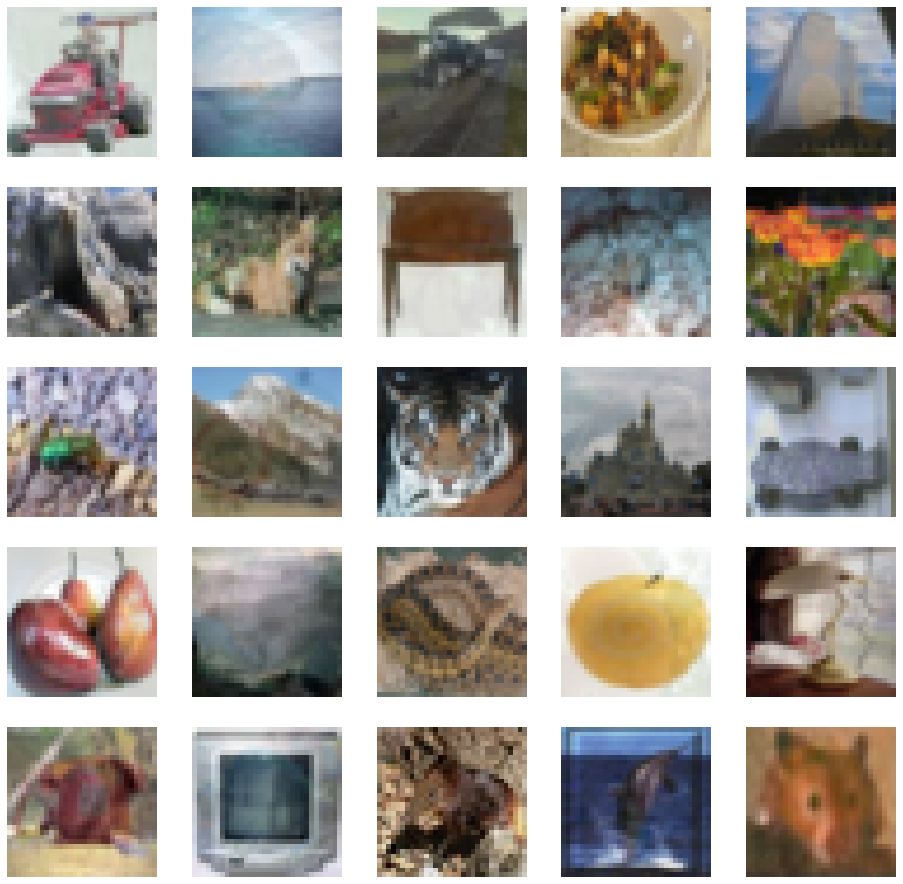

In [6]:
plt.figure(figsize=(16, 16))
for i, (image, label) in enumerate(zip(new_x_train[5:30], new_y_train[5:30])):
    ax = plt.subplot(5, 5, i + 1)
    plt.imshow(image)
    plt.axis("off")

In [10]:
def get_model():
    input_layer = tf.keras.layers.Input(shape=(32, 32, 3))
    
    conv_1 = tf.keras.layers.Conv2D(32, 3, activation="swish")(input_layer)
    conv_1 = tf.keras.layers.Dropout(.25)(conv_1)
    conv_1 = tf.keras.layers.Conv2D(64, 3, activation="swish")(conv_1)
    conv_1 = tf.keras.layers.Dropout(.25)(conv_1)
    conv_1 = tf.keras.layers.MaxPool2D()(conv_1)
    conv_1 = tf.keras.layers.BatchNormalization()(conv_1)
    
    conv_2 = tf.keras.layers.Conv2D(128, 3, activation="swish")(conv_1)
    conv_2 = tf.keras.layers.Dropout(.33)(conv_2)
    conv_2 = tf.keras.layers.Conv2D(256, 3, activation="swish")(conv_2)
    conv_2 = tf.keras.layers.Dropout(.33)(conv_2)
    conv_2 = tf.keras.layers.MaxPool2D()(conv_2)
    conv_2 = tf.keras.layers.BatchNormalization()(conv_2)
    
    dense = tf.keras.layers.Flatten()(conv_2)
    
    dense = tf.keras.layers.Dense(256, activation="swish")(dense)
    dense = tf.keras.layers.Dropout(.5)(dense)
    dense = tf.keras.layers.Dense(256, activation="swish")(dense)
    dense = tf.keras.layers.Dropout(.5)(dense)
    
    output_layer = tf.keras.layers.Dense(100, activation="softmax")(dense)
    
    model = tf.keras.Model(inputs=input_layer, outputs=output_layer)
    
    model.compile(
        loss=tf.keras.losses.CategoricalCrossentropy(),
        metrics=tf.keras.metrics.TopKCategoricalAccuracy(k=10),
        optimizer=tf.keras.optimizers.Adam()
    )
    
    model.summary()
    
    return model

In [11]:
model_norm = get_model()
model_mixup = get_model()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_8 (Conv2D)           (None, 30, 30, 32)        896       
                                                                 
 dropout_12 (Dropout)        (None, 30, 30, 32)        0         
                                                                 
 conv2d_9 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 dropout_13 (Dropout)        (None, 28, 28, 64)        0         
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                             
                                                           

In [12]:
history_norm = model_norm.fit(x_train[2000:], y_train[2000:], epochs=50, batch_size=256, validation_data=(x_train[:2000], y_train[:2000]), verbose=2)

Epoch 1/50
188/188 - 9s - loss: 4.6228 - top_k_categorical_accuracy: 0.2031 - val_loss: 4.6329 - val_top_k_categorical_accuracy: 0.1030 - 9s/epoch - 46ms/step
Epoch 2/50
188/188 - 7s - loss: 4.1704 - top_k_categorical_accuracy: 0.3572 - val_loss: 5.1963 - val_top_k_categorical_accuracy: 0.1260 - 7s/epoch - 37ms/step
Epoch 3/50
188/188 - 7s - loss: 3.8848 - top_k_categorical_accuracy: 0.4561 - val_loss: 4.9156 - val_top_k_categorical_accuracy: 0.2160 - 7s/epoch - 37ms/step
Epoch 4/50
188/188 - 7s - loss: 3.6390 - top_k_categorical_accuracy: 0.5330 - val_loss: 4.2733 - val_top_k_categorical_accuracy: 0.3300 - 7s/epoch - 38ms/step
Epoch 5/50
188/188 - 7s - loss: 3.4150 - top_k_categorical_accuracy: 0.5971 - val_loss: 3.6398 - val_top_k_categorical_accuracy: 0.5160 - 7s/epoch - 40ms/step
Epoch 6/50
188/188 - 8s - loss: 3.2071 - top_k_categorical_accuracy: 0.6500 - val_loss: 3.5682 - val_top_k_categorical_accuracy: 0.5400 - 8s/epoch - 40ms/step
Epoch 7/50
188/188 - 8s - loss: 3.0331 - top_k

In [13]:
history_mixup = model_mixup.fit(new_x_train[2000:], new_y_train[2000:], epochs=5, batch_size=256, validation_data=(new_x_train[:2000], new_y_train[:2000]), verbose=2)

Epoch 1/5
1946/1946 - 101s - loss: 3.8041 - top_k_categorical_accuracy: 0.5684 - val_loss: 3.4223 - val_top_k_categorical_accuracy: 0.6960 - 101s/epoch - 52ms/step
Epoch 2/5
1946/1946 - 93s - loss: 2.9085 - top_k_categorical_accuracy: 0.8477 - val_loss: 2.9716 - val_top_k_categorical_accuracy: 0.8355 - 93s/epoch - 48ms/step
Epoch 3/5
1946/1946 - 105s - loss: 2.5662 - top_k_categorical_accuracy: 0.9125 - val_loss: 2.6619 - val_top_k_categorical_accuracy: 0.8995 - 105s/epoch - 54ms/step
Epoch 4/5
1946/1946 - 100s - loss: 2.3876 - top_k_categorical_accuracy: 0.9392 - val_loss: 2.5111 - val_top_k_categorical_accuracy: 0.9315 - 100s/epoch - 52ms/step
Epoch 5/5
1946/1946 - 101s - loss: 2.2719 - top_k_categorical_accuracy: 0.9541 - val_loss: 2.2447 - val_top_k_categorical_accuracy: 0.9625 - 101s/epoch - 52ms/step


In [15]:
norm_res = model_norm.evaluate(x_test, y_test, batch_size=256)
mixup_res = model_mixup.evaluate(x_test, y_test, batch_size=256)

print('--- results ---')
print('normal :', norm_res)
print('mixup  :', mixup_res)

40/40 [==============================] - 1s 12ms/step - loss: 2.1073 - top_k_categorical_accuracy: 0.8454
--- results ---
normal : [2.819321393966675, 0.7950999736785889]
mixup  : [2.1072840690612793, 0.8453999757766724]
